In [1]:
import os.path
import argparse
import numpy as np
from math import log, exp, ceil
print(np.version.version)

1.16.4


In [2]:
# Default Arguments
gamma = 15                    # Biasfactor in well-tempered metadynamics.
kT = 2.5                      # Temperature times Boltzmann constant.
fesfilename = "data/fes_" # FES file name start.
col_fe = 1                    # Column of free energy.
datafile = "data/SHORT"           # COLVAR file name.
col_rewt = [2]          # COLVAR columns corresponding to RC variables.
col_bias = [3]                # COLVAR bias column.
ngrid = 30                    # Number of grid bins.

In [3]:
def ebc(num):
    global colvar,ebetac
    # File Inputs
    tmp = 2500000 * (num + 1) + 1
    colvar = np.loadtxt(datafile, max_rows=tmp)

    # Calculating c(t):
    # calculates ebetac = exp(beta c(t)), using eq. 12 in eq. 3 in the JPCB paper
    #
    ebetac = []

    for i in range(num + 1):
        # set appropriate format for FES file names, NB: i starts from 0
        fname = '%s%d.dat' % (fesfilename,i)

        data = np.loadtxt(fname)
        s1, s2 = 0., 0.
        for p in data:
            exponent = -p[col_fe]/kT
            s1 += exp(exponent)
            s2 += exp(exponent/gamma)
        ebetac += s1 / s2,

In [4]:
def weights(num):
    # compute reweighting weights from FES data and bias column
    global kT, col_bias, weight
    numcolv = np.shape(colvar)[0]
    weight = np.zeros(numcolv)

    # go through the CV(t) trajectory
    i = 0
    for row in colvar:
        i += 1
        indx = int(ceil(float(i)/numcolv*(num + 1)))-1
        bias = sum([row[j] for j in col_bias])
        ebias = exp(bias/kT)/ebetac[indx]
        weight[i-1] = ebias

In [5]:
def load(num):
    # Loads given files. Runs on import to prevent redundant loading, note this increases import time.
    ebc(num)
    weights(num)

In [6]:
def reweight(sparse=False,size=30,data=None):
    # Reweighting biased MD trajectory to unbiased probabilty along a given RC.
    # By default (sparse=False) bins on the edge of the range with probabilities lower
    # than 1/N where N is number of data points will be removed.
    global kT, fesfilename, col_fe, datafile, col_rewt, numrewt, col_bias, ngrid, s_min, s_max

    rc = [1]

    if data != None:
        datafile = data
        load()

    rc_space = np.dot(colvar[:,col_rewt],rc)
    s_max = np.max(rc_space)
    s_min = np.min(rc_space)



    # initialize square array numrewt-dimensional


    hist = np.histogram(rc_space,size,weights=weight)[0]
    pnorm = hist/np.sum(hist)



    # Trimming off probability values less than one data point could provide
    if not sparse:
        cutoff = 1/np.shape(colvar)[0]
        trim = np.nonzero(pnorm >= cutoff)
        trimmed = pnorm[np.min(trim):np.max(trim)+1]
        if np.min(trimmed) < cutoff:
            cutoff = np.min(trimmed)
            trim = np.nonzero(pnorm >= cutoff)
            trimmed = pnorm[np.min(trim):np.max(trim)+1]
        return trimmed
    return pnorm

In [10]:
vals= []
for i in range(4):
    load(i)
    plz = reweight()
    print(plz)
    vals.append(plz)

[3.03817170e-03 1.63944475e-02 3.85331031e-02 1.29515536e-01
 4.44207943e-01 1.48845770e-01 1.16247977e-01 4.38793473e-02
 2.22478371e-02 1.93514332e-02 4.99046395e-03 3.02596822e-03
 2.86244049e-03 1.66909912e-03 1.78407779e-03 7.80470053e-04
 6.79321548e-04 9.91093074e-05 2.41394424e-05 4.13347435e-05
 4.49339715e-05 3.63794414e-05 3.37235431e-04 3.43274202e-04
 7.77485830e-04 1.93698778e-04 1.50182892e-05 3.11140770e-05
 2.86725976e-06]
[0.00282512 0.01226811 0.03100926 0.11875334 0.3271755  0.09678923
 0.08406491 0.02763397 0.02830035 0.01312749 0.01109739 0.0354453
 0.01675253 0.03048361 0.03155114 0.03352352 0.03115344 0.01397026
 0.00621347 0.00308238 0.00402174 0.00683536 0.00545045 0.0023125
 0.00569049 0.00534449 0.00128399 0.01149873 0.00234191]
[9.19367029e-06 1.85339449e-03 2.99941230e-03 5.64780492e-03
 1.64449042e-02 7.91778797e-03 9.08422144e-03 1.46980977e-02
 2.73405928e-02 4.57497678e-02 7.54848316e-02 5.12723409e-02
 7.24125427e-02 9.23977015e-02 1.66543202e-01 1.81

In [4]:
file = open("data/SHORT")
for line in file:
    if "#!" not in line and float(line.split()[1]) > 1.0:
        print(line)
        break;
file.close()

 58.626000 1.000501 -6.422747 8.218810



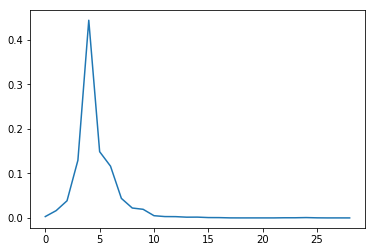

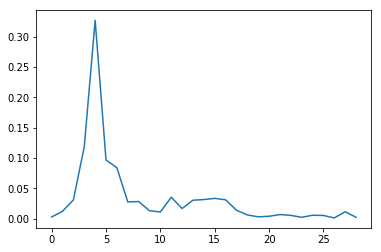

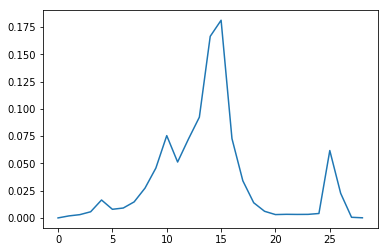

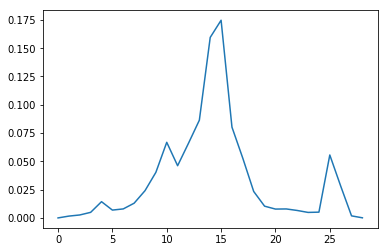

In [15]:
import matplotlib.pyplot as plt
for i in vals:
    plt.plot(i)
    plt.show()